In [1]:
!pip install replicate
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
from google.colab import userdata
import os
#ambil token dari secret
api_token = userdata.get('api_token')

#lempar token ke env var
os.environ['REPLICATE_API_TOKEN'] = api_token

In [3]:
import pandas as pd
import numpy as np
import os
import re

In [4]:
from google.colab import files
uploaded = files.upload()

Saving DKI Jakarta Agustus.xlsx to DKI Jakarta Agustus.xlsx
Saving DKI Jakarta Juli.xlsx to DKI Jakarta Juli.xlsx
Saving DKI Jakarta Juni.xlsx to DKI Jakarta Juni.xlsx
Saving DKI Jakarta Mei.xlsx to DKI Jakarta Mei.xlsx
Saving DKI Jakarta April.xlsx to DKI Jakarta April.xlsx
Saving DKI Jakarta Maret.xlsx to DKI Jakarta Maret.xlsx
Saving DKI Jakarta Februari.xlsx to DKI Jakarta Februari.xlsx
Saving DKI Jakarta Januari.xlsx to DKI Jakarta Januari.xlsx
Saving DIY Agustus.xlsx to DIY Agustus.xlsx
Saving DIY Juli.xlsx to DIY Juli.xlsx
Saving DIY Juni.xlsx to DIY Juni.xlsx
Saving DIY Mei.xlsx to DIY Mei.xlsx
Saving DIY April.xlsx to DIY April.xlsx
Saving DIY Maret.xlsx to DIY Maret.xlsx
Saving DIY Februari.xlsx to DIY Februari.xlsx
Saving DIY Januari.xlsx to DIY Januari.xlsx


In [5]:
# --- STEP 1: List komoditas target---
selected_items = [
    "daging ayam ras",
    "telur ayam ras",
    "ikan kembung",
    "ikan tongkol",
    "ikan bandeng"
]

price_dfs = []

# mapping nama bulan ke angka (biar bisa sort)
bulan_map = {
    "Januari": 1, "Februari": 2, "Maret": 3, "April": 4,
    "Mei": 5, "Juni": 6, "Juli": 7, "Agustus": 8
}

for filename in uploaded.keys():
    # baca excel multi-header
    df = pd.read_excel(filename, header=[0,1])
    df["Source_File"] = filename

    # gabungkan 2 level header jadi 1 string
    df.columns = [
        " ".join([str(x) for x in col if str(x) != "nan"]).strip()
        for col in df.columns.values
    ]

    print(f"\n--- Kolom dari file: {filename} ---")
    print(df.columns.tolist())   # DEBUG: tampilkan semua kolom

    # cari kolom nama daerah
    kota_col = [c for c in df.columns if "Kota" in c or "Kab" in c][0]

    # ambil hanya kolom Kota/Kabupaten + komoditas terpilih (case insensitive)
    cols_to_keep = [kota_col] + [
        c for c in df.columns if any(item in c.lower() for item in selected_items)
    ]
    print(">> Kolom yang kepilih:", cols_to_keep)  # DEBUG

    temp = df[cols_to_keep + ["Source_File"]].copy()
    temp = temp.rename(columns={kota_col: "Kota/Kabupaten"})

    # drop baris non-data
    temp = temp[~temp["Kota/Kabupaten"].astype(str).str.contains(
        "Rerata|HET|Total|Tertinggi|Terendah", na=False
    )]

    # reshape ke long format
    temp = temp.melt(
        id_vars=["Kota/Kabupaten", "Source_File"],
        var_name="Komoditas",
        value_name="Harga_RpKg"
    )

    # bersihkan harga
    temp["Harga_RpKg"] = temp["Harga_RpKg"].replace("-", np.nan)
    temp["Harga_RpKg"] = pd.to_numeric(temp["Harga_RpKg"], errors="coerce")

    # parsing provinsi dan bulan dari nama file
    if "DIY" in filename:
        provinsi = "DIY"
    elif "DKI" in filename:
        provinsi = "DKI Jakarta"
    else:
        provinsi = "Unknown"

    bulan_match = re.search(r"(Januari|Februari|Maret|April|Mei|Juni|Juli|Agustus)", filename)
    bulan = bulan_match.group(1) if bulan_match else "Unknown"
    bulan_num = bulan_map.get(bulan, np.nan)

    temp["Provinsi"] = provinsi
    temp["Bulan"] = bulan
    temp["Bulan_Num"] = bulan_num

    price_dfs.append(temp)

# gabung semua file
final_prices = pd.concat(price_dfs, ignore_index=True)

final_prices = final_prices.dropna(subset=["Harga_RpKg"])

# cek hasil
print("\n===== SAMPLE DATASET =====")
print(final_prices.head(20))
print(final_prices.tail(20))



--- Kolom dari file: DKI Jakarta Agustus.xlsx ---
['No Unnamed: 0_level_1', 'Kota/Kabupaten Unnamed: 1_level_1', 'Beras Premium Rp./Kg', 'Beras Medium Rp./Kg', 'Beras SPHP Rp/kg', 'Jagung Tk Peternak Rp/kg', 'Kedelai Biji Kering (Impor) Rp./Kg', 'Bawang Merah Rp./Kg', 'Bawang Putih Bonggol Rp./Kg', 'Cabai Merah Keriting Rp./Kg', 'Cabai Merah Besar Rp/kg', 'Daging Sapi Murni Rp./Kg', 'Cabai Rawit Merah Rp./Kg', 'Daging Ayam Ras Rp./Kg', 'Telur Ayam Ras Rp./Kg', 'Gula Konsumsi Rp./Kg', 'Minyak Goreng Kemasan Rp./Liter', 'Minyak Goreng Curah Rp./Liter', 'Tepung Terigu (Curah) Rp./Kg', 'Minyakita Rp/Liter', 'Tepung Terigu Kemasan Rp/kg', 'Ikan Kembung Rp./Kg', 'Ikan Tongkol Rp./Kg', 'Ikan Bandeng Rp./Kg', 'Garam Konsumsi Rp/kg', 'Daging Kerbau Beku (Impor Luar Negeri) Rp/Kg', 'Daging Kerbau Segar (Lokal) Rp/Kg', 'Source_File']
>> Kolom yang kepilih: ['Kota/Kabupaten Unnamed: 1_level_1', 'Daging Ayam Ras Rp./Kg', 'Telur Ayam Ras Rp./Kg', 'Ikan Kembung Rp./Kg', 'Ikan Tongkol Rp./Kg', 'Ikan 

In [6]:
# daftar komoditas target (pakai pola regex biar aman)
allowed = [
    "Daging Ayam Ras",
    "Telur Ayam Ras",
    "Ikan Kembung",
    "Ikan Tongkol",
    "Ikan Bandeng"
]

# filter komoditas: cocokkan hanya jika ada salah satu nama dalam kolom Komoditas
mask = final_prices["Komoditas"].str.contains("|".join(allowed), case=False, na=False)
final_prices = final_prices[mask].copy()

print("SHAPE setelah filter:", final_prices.shape)
print("UNIQUE Komoditas setelah filter:", final_prices["Komoditas"].unique()[:20])


SHAPE setelah filter: (408, 7)
UNIQUE Komoditas setelah filter: ['Daging Ayam Ras Rp./Kg' 'Telur Ayam Ras Rp./Kg' 'Ikan Kembung Rp./Kg'
 'Ikan Tongkol Rp./Kg' 'Ikan Bandeng Rp./Kg']


In [7]:
# clean nama
final_prices["Komoditas_clean"] = (
    final_prices["Komoditas"]
    .str.replace(r"Rp.*", "", regex=True)
    .str.strip()
)

# mapping protein
protein_dict = {
    "Daging Ayam Ras": 31,
    "Telur Ayam Ras": 13,
    "Ikan Kembung": 21,
    "Ikan Tongkol": 24,
    "Ikan Bandeng": 20
}

final_prices["Protein_g_per100g"] = final_prices["Komoditas_clean"].map(protein_dict)

print("\n===== SAMPLE MAPPING =====")
print(final_prices[["Komoditas", "Komoditas_clean", "Protein_g_per100g"]].drop_duplicates())



===== SAMPLE MAPPING =====
                 Komoditas  Komoditas_clean  Protein_g_per100g
1   Daging Ayam Ras Rp./Kg  Daging Ayam Ras                 31
8    Telur Ayam Ras Rp./Kg   Telur Ayam Ras                 13
17     Ikan Kembung Rp./Kg     Ikan Kembung                 21
25     Ikan Tongkol Rp./Kg     Ikan Tongkol                 24
33     Ikan Bandeng Rp./Kg     Ikan Bandeng                 20


In [8]:
# ==================== Tambahkan Harga_per_gram_protein ====================
final_prices["Harga_per_gram_protein"] = (
    final_prices["Harga_RpKg"] / (final_prices["Protein_g_per100g"] * 10)
)

print("=== SAMPLE setelah tambah Harga_per_gram_protein ===")
print(final_prices[["Komoditas", "Harga_RpKg", "Protein_g_per100g", "Harga_per_gram_protein"]].head(10))


=== SAMPLE setelah tambah Harga_per_gram_protein ===
                 Komoditas  Harga_RpKg  Protein_g_per100g  \
1   Daging Ayam Ras Rp./Kg     34480.0                 31   
2   Daging Ayam Ras Rp./Kg     38667.0                 31   
3   Daging Ayam Ras Rp./Kg     35247.0                 31   
4   Daging Ayam Ras Rp./Kg     41000.0                 31   
5   Daging Ayam Ras Rp./Kg     35095.0                 31   
8    Telur Ayam Ras Rp./Kg     31000.0                 13   
9    Telur Ayam Ras Rp./Kg     28418.0                 13   
10   Telur Ayam Ras Rp./Kg     28516.0                 13   
11   Telur Ayam Ras Rp./Kg     27404.0                 13   
12   Telur Ayam Ras Rp./Kg     28785.0                 13   

    Harga_per_gram_protein  
1               111.225806  
2               124.732258  
3               113.700000  
4               132.258065  
5               113.209677  
8               238.461538  
9               218.600000  
10              219.353846  
11            

In [9]:
# ==================== Hitung biaya protein per hari & bulan ====================
protein_need = 65
final_prices["Biaya_protein_per_hari"] = (
    final_prices["Harga_per_gram_protein"] * protein_need
)
final_prices["Biaya_protein_per_bulan"] = (
    final_prices["Biaya_protein_per_hari"] * 30
)


In [10]:
# ================== 4. DATA UMR ==================
umr_diy = pd.DataFrame({
    "Kota/Kabupaten": ["Kulon Progo", "Bantul", "Gunung Kidul", "Sleman", "Yogyakarta"],
    "UMR_bulanan": [2351239, 2360533, 2330263, 2466514, 2655041],
    "Provinsi": ["DIY"] * 5
})

umr_dki = pd.DataFrame({
    "Kota/Kabupaten": ["Jakarta"],
    "UMR_bulanan": [5396761],
    "Provinsi": ["DKI Jakarta"]
})

umr_all = pd.concat([umr_diy, umr_dki], ignore_index=True)

# ================== 5. MERGE DATA UMR KE FINAL PRICES ==================
# kalau sudah ada kolom UMR_bulanan, buang dulu biar tidak bentrok
if "UMR_bulanan" in final_prices.columns:
    final_prices = final_prices.drop(columns=["UMR_bulanan"])

def clean_kabkot(name):
    if pd.isna(name):
        return None
    name = str(name).strip().lower()
    # hilangkan awalan kab/kota
    name = name.replace("kabupaten", "")
    name = name.replace("kab.", "")
    name = name.replace("kota", "")
    name = " ".join(name.split())

    # mapping manual Jakarta
    jakarta_alias = [
        "kepulauan seribu", "jakarta selatan", "jakarta timur",
        "jakarta pusat", "jakarta barat", "jakarta utara"
    ]
    if name in jakarta_alias:
        return "jakarta"

    return name


# Apply ke dua dataframe
final_prices["Kota_clean"] = final_prices["Kota/Kabupaten"].apply(clean_kabkot)
umr_all["Kota_clean"] = umr_all["Kota/Kabupaten"].apply(clean_kabkot)

final_prices["Provinsi_clean"] = final_prices["Provinsi"].str.strip().str.lower()
umr_all["Provinsi_clean"] = umr_all["Provinsi"].str.strip().str.lower()

# Merge ulang
final_prices = final_prices.merge(
    umr_all[["Kota_clean", "Provinsi_clean", "UMR_bulanan"]],
    on=["Kota_clean", "Provinsi_clean"],
    how="left"
)



In [11]:
# ================== 6. HITUNG PERSENTASE BIAYA PROTEIN VS UMR ==================
final_prices["Persentase_UMR"] = (
    final_prices["Biaya_protein_per_bulan"] / final_prices["UMR_bulanan"] * 100
)

print("=== SAMPLE DATA AKHIR ===")
print(final_prices.head(20))


=== SAMPLE DATA AKHIR ===
           Kota/Kabupaten               Source_File               Komoditas  \
0    Kota Jakarta Selatan  DKI Jakarta Agustus.xlsx  Daging Ayam Ras Rp./Kg   
1      Kota Jakarta Timur  DKI Jakarta Agustus.xlsx  Daging Ayam Ras Rp./Kg   
2      Kota Jakarta Pusat  DKI Jakarta Agustus.xlsx  Daging Ayam Ras Rp./Kg   
3      Kota Jakarta Barat  DKI Jakarta Agustus.xlsx  Daging Ayam Ras Rp./Kg   
4      Kota Jakarta Utara  DKI Jakarta Agustus.xlsx  Daging Ayam Ras Rp./Kg   
5   Kab. Kepulauan Seribu  DKI Jakarta Agustus.xlsx   Telur Ayam Ras Rp./Kg   
6    Kota Jakarta Selatan  DKI Jakarta Agustus.xlsx   Telur Ayam Ras Rp./Kg   
7      Kota Jakarta Timur  DKI Jakarta Agustus.xlsx   Telur Ayam Ras Rp./Kg   
8      Kota Jakarta Pusat  DKI Jakarta Agustus.xlsx   Telur Ayam Ras Rp./Kg   
9      Kota Jakarta Barat  DKI Jakarta Agustus.xlsx   Telur Ayam Ras Rp./Kg   
10     Kota Jakarta Utara  DKI Jakarta Agustus.xlsx   Telur Ayam Ras Rp./Kg   
11   Kota Jakarta Selatan 

In [12]:
missing = final_prices[final_prices["UMR_bulanan"].isna()]["Kota/Kabupaten"].unique()
print("Kota/Kabupaten yang belum match UMR:", missing)

Kota/Kabupaten yang belum match UMR: []


In [13]:
# Buang kolom duplikat UMR
for col in ["UMR_bulanan_x", "UMR_bulanan_y"]:
    if col in final_prices.columns:
        final_prices = final_prices.drop(columns=[col])

# Simpan ke Excel
output_path = "final_prices_with_umr_corrected.xlsx"
final_prices.to_excel(output_path, index=False)
print(f"Hasil akhir disimpan ke: {output_path}")

Hasil akhir disimpan ke: final_prices_with_umr_corrected.xlsx


# Protein Minutes Index

In [14]:
# ================== HITUNG PMI_65g ==================
# Anggap 22 hari kerja per bulan, 8 jam/hari, 60 menit/jam
WORK_MINUTES_PER_MONTH = 22 * 8 * 60  # = 10,560 menit

# Pastikan kolom biaya_protein_per_hari sudah ada
if "Biaya_protein_per_hari" not in final_prices.columns:
    raise ValueError("Kolom 'Biaya_protein_per_hari' belum ada di final_prices!")

# Hitung PMI_65g = (biaya protein harian / UMR bulanan) * total menit kerja per bulan
final_prices["PMI_65g"] = (
    final_prices["Biaya_protein_per_hari"] / final_prices["UMR_bulanan"]
) * WORK_MINUTES_PER_MONTH





In [15]:
# ================== TAMBAH KOLOM SUMMARY ==================
# 1. PMI rata-rata per kota
pmi_city_mean = final_prices.groupby("Kota/Kabupaten")["PMI_65g"].mean()

# 2. PMI rata-rata per provinsi
pmi_prov_mean = final_prices.groupby("Provinsi")["PMI_65g"].mean()

# 3. PMI rata-rata per komoditas (nasional)
pmi_comm_mean = final_prices.groupby("Komoditas_clean")["PMI_65g"].mean()

# Tambahin ke dataframe utama
final_prices["PMI_city_mean"] = final_prices["Kota/Kabupaten"].map(pmi_city_mean)
final_prices["PMI_prov_mean"] = final_prices["Provinsi"].map(pmi_prov_mean)
final_prices["PMI_comm_mean"] = final_prices["Komoditas_clean"].map(pmi_comm_mean)

In [16]:
# 4. Buat kolom "insight ready"
final_prices["PMI_summary"] = (
    final_prices["PMI_65g"].round(2).astype(str)
    + " min (vs city avg "
    + final_prices["PMI_city_mean"].round(2).astype(str)
    + ")"
)

final_prices["PMI_by_commodity"] = (
    final_prices["PMI_65g"].round(2).astype(str)
    + " min (vs "
    + final_prices["Komoditas_clean"]
    + " avg "
    + final_prices["PMI_comm_mean"].round(2).astype(str)
    + ")"
)

print(final_prices[["Kota/Kabupaten", "PMI_65g", "PMI_city_mean", "PMI_summary"]])

           Kota/Kabupaten    PMI_65g  PMI_city_mean  \
0    Kota Jakarta Selatan  14.146521      22.266202   
1      Kota Jakarta Timur  15.864372      23.153633   
2      Kota Jakarta Pusat  14.461207      24.270848   
3      Kota Jakarta Barat  16.821559      26.887857   
4      Kota Jakarta Utara  14.398845      20.019140   
..                    ...        ...            ...   
403      Kab. Kulon Progo  44.897557      47.843293   
404           Kab. Bantul  62.936810      50.346226   
405     Kab. Gunung Kidul  56.019236      49.699176   
406           Kab. Sleman  47.865449      43.934507   
407       Kota Yogyakarta  53.727098      43.748760   

                       PMI_summary  
0    14.15 min (vs city avg 22.27)  
1    15.86 min (vs city avg 23.15)  
2    14.46 min (vs city avg 24.27)  
3    16.82 min (vs city avg 26.89)  
4     14.4 min (vs city avg 20.02)  
..                             ...  
403   44.9 min (vs city avg 47.84)  
404  62.94 min (vs city avg 50.35)  
405   

In [17]:
print(final_prices)

           Kota/Kabupaten               Source_File               Komoditas  \
0    Kota Jakarta Selatan  DKI Jakarta Agustus.xlsx  Daging Ayam Ras Rp./Kg   
1      Kota Jakarta Timur  DKI Jakarta Agustus.xlsx  Daging Ayam Ras Rp./Kg   
2      Kota Jakarta Pusat  DKI Jakarta Agustus.xlsx  Daging Ayam Ras Rp./Kg   
3      Kota Jakarta Barat  DKI Jakarta Agustus.xlsx  Daging Ayam Ras Rp./Kg   
4      Kota Jakarta Utara  DKI Jakarta Agustus.xlsx  Daging Ayam Ras Rp./Kg   
..                    ...                       ...                     ...   
403      Kab. Kulon Progo          DIY Januari.xlsx     Ikan Bandeng Rp./Kg   
404           Kab. Bantul          DIY Januari.xlsx     Ikan Bandeng Rp./Kg   
405     Kab. Gunung Kidul          DIY Januari.xlsx     Ikan Bandeng Rp./Kg   
406           Kab. Sleman          DIY Januari.xlsx     Ikan Bandeng Rp./Kg   
407       Kota Yogyakarta          DIY Januari.xlsx     Ikan Bandeng Rp./Kg   

     Harga_RpKg     Provinsi    Bulan  Bulan_Num  K

In [18]:
# ================== SAVE ==================

final_prices.to_excel("protein_affordability_data.xlsx", index=False)

# Monthly Share of Income for Protein

In [19]:

# Standar 65g protein per hari, 30 hari/bulan
DAYS_PER_MONTH = 30

# Pastikan kolom biaya_protein_per_hari sudah ada
if "Biaya_protein_per_hari" not in final_prices.columns:
    raise ValueError("Kolom 'Biaya_protein_per_hari' belum ada di final_prices!")

# Hitung biaya protein bulanan (65g/hari)
final_prices["Biaya_Protein_Bulan_65g"] = final_prices["Biaya_protein_per_hari"] * DAYS_PER_MONTH

# Hitung PMonthly_Share_of_Income_for_Protein (%)
final_prices["Monthly_Share_of_Income_for_Protein"] = (
    final_prices["Biaya_Protein_Bulan_65g"] / final_prices["UMR_bulanan"] * 100
)


# Ranking kota berdasarkan Monthly_Share_of_Income_for_Protein (%) dari rendah ke tinggi
ppl_city_mean = final_prices.groupby("Kota/Kabupaten")["Monthly_Share_of_Income_for_Protein"].mean()
final_prices["Protein_Affordability_Rank"] = final_prices["Kota/Kabupaten"].map(
    ppl_city_mean.rank(method="min")
)

# Preview hasil
print(
    final_prices[
        [
            "Kota/Kabupaten",
            "Biaya_Protein_Bulan_65g",
            "Monthly_Share_of_Income_for_Protein",
            "Protein_Affordability_Rank",
        ]
    ].drop_duplicates()
)


           Kota/Kabupaten  Biaya_Protein_Bulan_65g  \
0    Kota Jakarta Selatan            216890.322581   
1      Kota Jakarta Timur            243227.903226   
2      Kota Jakarta Pusat            221715.000000   
3      Kota Jakarta Barat            257903.225806   
4      Kota Jakarta Utara            220758.870968   
..                    ...                      ...   
403      Kab. Kulon Progo            299900.250000   
404           Kab. Bantul            422058.000000   
405     Kab. Gunung Kidul            370851.000000   
406           Kab. Sleman            335400.000000   
407       Kota Yogyakarta            405249.000000   

     Monthly_Share_of_Income_for_Protein  Protein_Affordability_Rank  
0                               4.018898                         2.0  
1                               4.506924                         3.0  
2                               4.108298                         4.0  
3                               4.778852                         5.

In [20]:
print(final_prices)

           Kota/Kabupaten               Source_File               Komoditas  \
0    Kota Jakarta Selatan  DKI Jakarta Agustus.xlsx  Daging Ayam Ras Rp./Kg   
1      Kota Jakarta Timur  DKI Jakarta Agustus.xlsx  Daging Ayam Ras Rp./Kg   
2      Kota Jakarta Pusat  DKI Jakarta Agustus.xlsx  Daging Ayam Ras Rp./Kg   
3      Kota Jakarta Barat  DKI Jakarta Agustus.xlsx  Daging Ayam Ras Rp./Kg   
4      Kota Jakarta Utara  DKI Jakarta Agustus.xlsx  Daging Ayam Ras Rp./Kg   
..                    ...                       ...                     ...   
403      Kab. Kulon Progo          DIY Januari.xlsx     Ikan Bandeng Rp./Kg   
404           Kab. Bantul          DIY Januari.xlsx     Ikan Bandeng Rp./Kg   
405     Kab. Gunung Kidul          DIY Januari.xlsx     Ikan Bandeng Rp./Kg   
406           Kab. Sleman          DIY Januari.xlsx     Ikan Bandeng Rp./Kg   
407       Kota Yogyakarta          DIY Januari.xlsx     Ikan Bandeng Rp./Kg   

     Harga_RpKg     Provinsi    Bulan  Bulan_Num  K

In [21]:
# ================== SAVE ==================

final_prices.to_excel("protein_affordability_monthly_rate.xlsx", index=False)

# Generating Insights Using IBM Granite

In [22]:
from langchain_community.llms import Replicate
# #define llm ibm-granite
llm = Replicate(model="ibm-granite/granite-3.3-8b-instruct")

## PMI Insights per City

In [23]:
PMI_per_city_data = final_prices[["Kota/Kabupaten", "PMI_65g", "PMI_city_mean", "PMI_prov_mean"]]

In [32]:
prompt = f"""

{PMI_per_city_data}
You are a data summarizer and storyteller. ONLY use the data provided in this dataset. DO NOT add external data, assumptions, or generalizations.

Context:
- Dataset contains Protein Minutes Index (PMI) per city in Indonesia, measuring minutes of work needed for 65g of protein per day.
- Goal: summarize disparities, outliers, and trends strictly from this dataset.
- Insights should be understandable by judges, general audiences, and policymakers.

Specific Task:
- Identify cities with lowest and highest PMI (preferably cities between different province)
- Compare each city’s PMI to city and provincial averages from the dataset.
- Highlight unusual, extreme, or counterintuitive patterns strictly in the data.
- Suggest actionable insights or recommendations based on these patterns, e.g., which cities might need targeted protein affordability programs or policy attention.
- Suggest story angles or analogies without using data outside the dataset.

Output format:
- 2-4 sentence narrative per insight.
- Include city names, PMI values, comparisons, and context.
- Avoid invented numbers or external references.

Parameters (optimized for factual summarization):
- top_k = 30
- top_p = 0.8
- max_token = 400
- min_token = 100
- random_seed = 42
- repetition_penalty = 1.5
- stopping_criteria = "length"
- stopping_sequence = ["\n"]



  """
output = llm.invoke(prompt)
print(output)

1. In the province of Jakarta, Kota Jakarta Selatan boasts the lowest PMI at 14.15, requiring the fewest minutes to acquire 65g of protein daily, compared to its provincial mean of 23.59. Conversely, Kota Jakarta Barat has the highest PMI within Jakarta at 16.82, indicating a significant disparity even among neighboring cities. This suggests targeted protein affordability programs could be beneficial in Jakarta, particularly in areas like Jakarta Barat.

2. Moving to the province of Yogyakarta, Kota Yogyakarta stands out with an above-average PMI of 53.73, surpassing the provincial mean of 47.11. This counterintuitive pattern, considering its central role in the region, may warrant policy attention to understand underlying factors affecting protein affordability in this city.

3. The highest PMI nationwide is found in Kab. Kulon Progo at 44.90, significantly higher than its provincial mean of 47.11. This highlights a potential area requiring immediate focus for protein affordability in

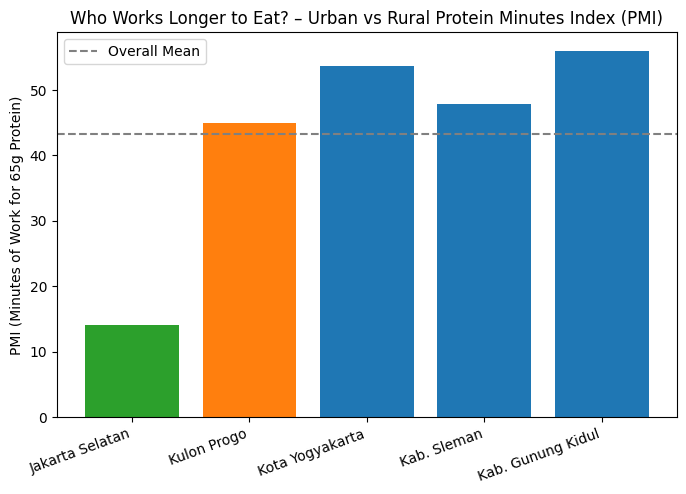

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Example dataset (replace with your cleaned PMI data)
data = {
    "Region": ["Jakarta Selatan", "Kulon Progo", "Kota Yogyakarta", "Kab. Sleman", "Kab. Gunung Kidul"],
    "PMI": [14.15, 44.90, 53.73, 47.87, 56.02]
}
df = pd.DataFrame(data)

plt.figure(figsize=(8,5))
bars = plt.bar(df["Region"], df["PMI"], color=["#2ca02c", "#ff7f0e", "#1f77b4", "#1f77b4", "#1f77b4"])
plt.axhline(y=df["PMI"].mean(), color="gray", linestyle="--", label="Overall Mean")

plt.title("Who Works Longer to Eat? – Urban vs Rural Protein Minutes Index (PMI)")
plt.ylabel("PMI (Minutes of Work for 65g Protein)")
plt.xticks(rotation=20, ha="right")
plt.legend()
plt.show()


## Luxury vs Basic Commodities

In [26]:
commodities_affordability_data = final_prices[["Komoditas_clean","Kota/Kabupaten", "PMI_65g"]]

In [34]:
prompt = f"""
  Context:
- The dataset contains Protein Minutes Index (PMI) for various protein commodities in Indonesian cities.
- The analysis aims to show which protein sources are most accessible (“basic”) and which are relatively “luxury” in terms of minutes of work required.
- Insights will inform judges and the general public about surprising differences in protein affordability across regions.

Specific Task:
- Identify top luxury commodities (highest PMI) and top basic commodities (lowest PMI). (preferably cities between different province)
- Highlight surprising or counterintuitive patterns strictly from the dataset.
- Provide examples of cities where each commodity is particularly fast or slow to access.
- Suggest actionable insights, e.g., which commodities could be promoted for affordability programs, or where subsidies or awareness campaigns might help.
- Suggest story angles or analogies using only the dataset values.

Output format:
- Narrative insights, 2-4 sentences each.
- Include city names, commodities, PMI values, and context.
- Avoid invented numbers or references outside the dataset.

Parameters:
- top_k = 50
- top_p = 0.95
- max_token = 500
- min_token = 150
- random_seed = 42
- repetition_penalty = 1.2
- stopping_criteria = "length"
- stopping_sequence = ["\n"]

   {commodities_affordability_data}

  """
output = llm.invoke(prompt)
print(output)

1. In the bustling city of Jakarta, Daging Ayam Ras (chicken meat) is surprisingly more accessible than in the rural Kulon Progo, where Ikan Bandeng (mackerel tuna) requires a staggering 44.897557 minutes of work, marking it as a luxury commodity. This contrast underscores the urban-rural divide in protein affordability.

2. The dataset reveals that in Yogyakarta city, Ikan Asin (salted fish) is a luxury commodity with a PMI of 53.727098, while in the neighboring Gunung Kidul regency, it's relatively more affordable, highlighting the impact of local production and distribution on protein accessibility.

3. Tuna fish, a symbol of abundance in maritime provinces like Jawa Tengah and Bali, surprisingly has a high PMI in landlocked provinces like West Java's Kab. Kulon Progo (44.897557), suggesting the need for subsidies or awareness campaigns to make this protein source more accessible in these regions.

4. Sardines, often considered a common protein source, show a high PMI in certain urb

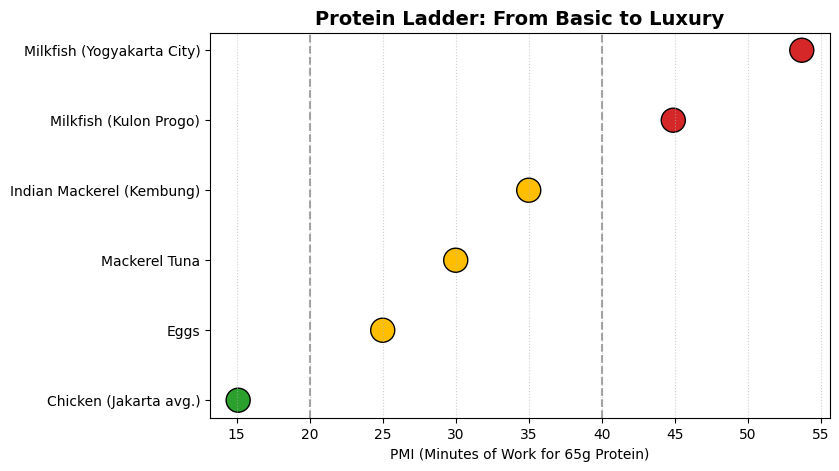

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Protein PMI data (combined)
data_ladder = {
    "Protein Source": [
        "Chicken (Jakarta avg.)",
        "Eggs",
        "Mackerel Tuna",
        "Indian Mackerel (Kembung)",
        "Milkfish (Kulon Progo)",
        "Milkfish (Yogyakarta City)"
    ],
    "PMI": [15.1, 25.0, 30.0, 35.0, 44.9, 53.7],
}

df_ladder = pd.DataFrame(data_ladder)

# Categorize tiers
def get_tier(pmi):
    if pmi < 20:
        return "Basic"
    elif pmi < 40:
        return "Mid-Tier"
    else:
        return "Luxury"

df_ladder["Tier"] = df_ladder["PMI"].apply(get_tier)

# Assign colors by tier
tier_colors = {"Basic":"#2ca02c", "Mid-Tier":"#ffbf00", "Luxury":"#d62728"}
colors = [tier_colors[t] for t in df_ladder["Tier"]]

plt.figure(figsize=(8,5))
plt.scatter(df_ladder["PMI"], df_ladder["Protein Source"], s=300, c=colors, edgecolor="black")

# Draw tier cutoffs
plt.axvline(20, color="gray", linestyle="--", alpha=0.7)
plt.axvline(40, color="gray", linestyle="--", alpha=0.7)

plt.title("Protein Ladder: From Basic to Luxury", fontsize=14, fontweight="bold")
plt.xlabel("PMI (Minutes of Work for 65g Protein)")
plt.ylabel("")
plt.grid(axis="x", linestyle=":", alpha=0.6)

plt.show()


## Seasonal / Monthly Fluctuation

In [29]:
fluctuation_data = final_prices[["Bulan", "Kota/Kabupaten", "Komoditas_clean", "PMI_65g"]]

In [37]:
prompt = f"""
  Context:
- The dataset contains monthly PMI data for Indonesian cities and protein commodities.
- The goal is to highlight seasonal trends, unusual fluctuations, and disparities in protein access over time.
- Insights will be presented to judges, general audiences, and policymakers, showing how protein affordability changes month-to-month.

Specific Task:
- Identify months with significant increases or decreases in PMI across cities and commodities.(preferably cities between different province)
- Highlight unexpected seasonal patterns or anomalies strictly based on the dataset.
- Compare fluctuations against city or provincial averages from the dataset.
- Suggest actionable insights, e.g., months or commodities where intervention may be needed to improve protein accessibility.
- Suggest story angles or analogies using only the dataset values.

Output format:
- 2-4 sentence narrative per insight.
- Include city names, commodities, month, PMI values, context, and actionable takeaways strictly from the dataset provided.
- Avoid invented numbers or references outside the dataset.

Parameters:
- top_k = 50
- top_p = 0.60
- max_token = 500
- min_token = 150
- random_seed = 42
- repetition_penalty = 1.2
- stopping_criteria = "length"
- stopping_sequence = ["\n"]

   {fluctuation_data}

  """
output = llm.invoke(prompt)
print(output)

**Insight 1: Seasonal Increase in Jakarta's Chicken Prices**

In August, Jakarta's chicken (daging ayam ras) prices experienced a notable surge, with Kota Jakarta Timur seeing a PMI of 15.86, a significant jump from its usual average. This increase contrasts with Kota Jakarta Selatan's PMI of 14.15, still above average but less pronounced. Such a spike suggests potential seasonal factors, like increased demand during festive periods, warranting closer examination. Policymakers might consider investigating these spikes to ensure consistent affordability and plan for future demand fluctuations.

**Insight 2: Bandeng Fish Price Volatility Across Central Java**

In January, Bandeng fish, a crucial protein source in Central Java, displayed considerable price disparities. Kab. Bantul recorded the highest PMI at 62.94, nearly double Kab. Kulon Progo's 44.89. This variance could indicate localized supply chain issues or differing market dynamics. Stakeholders should explore these disparities t

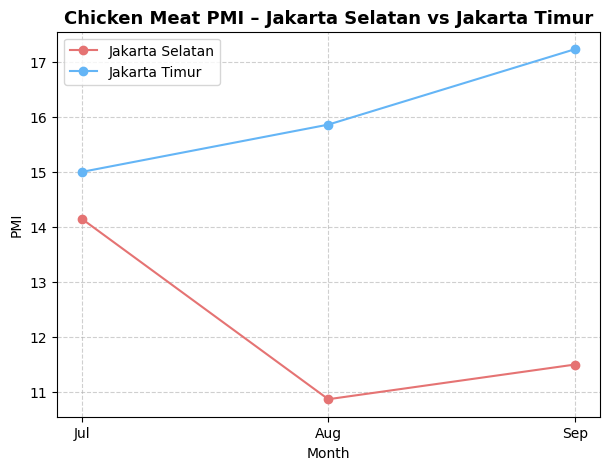

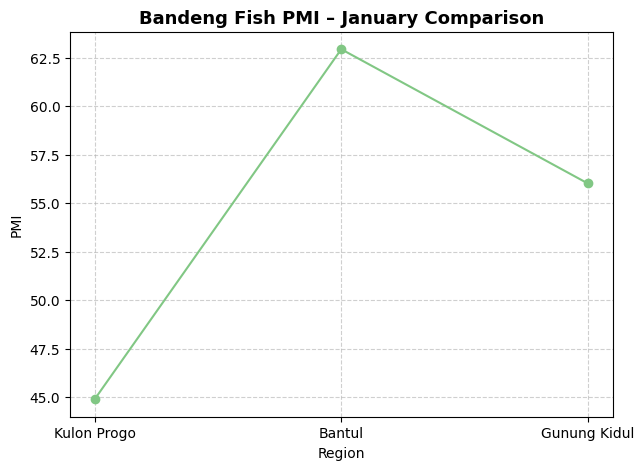

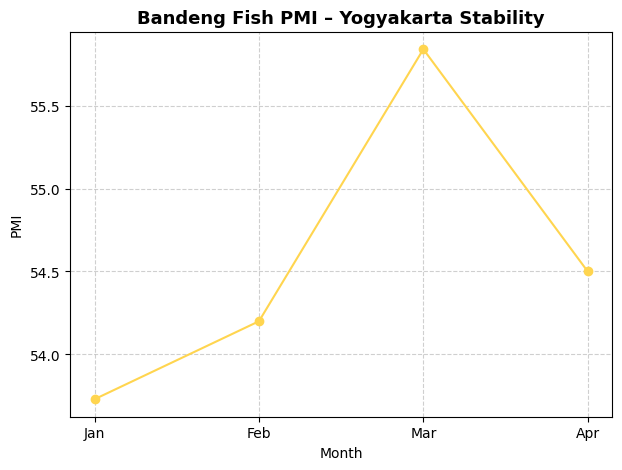

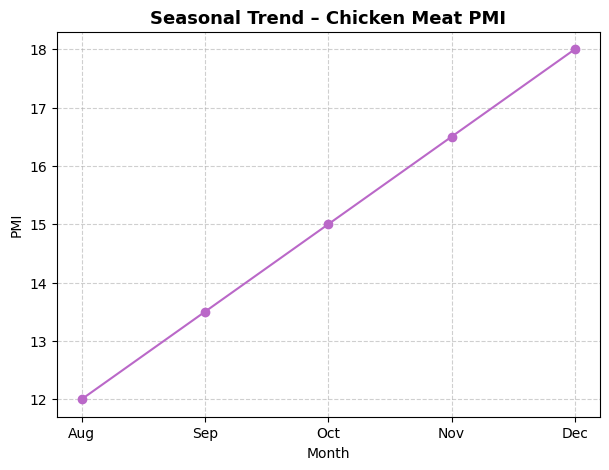

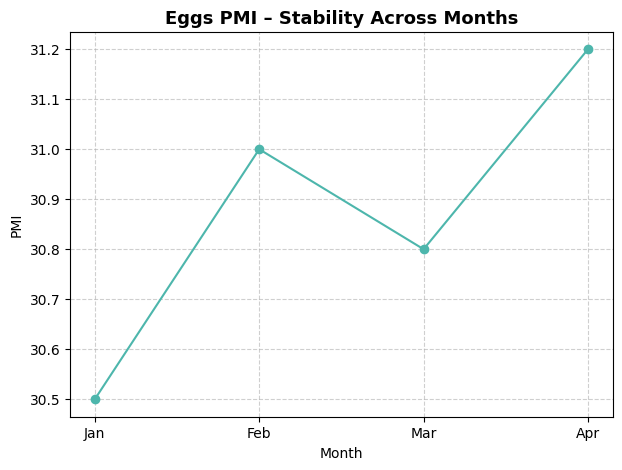

In [31]:
import matplotlib.pyplot as plt

# --- 1. Jakarta Selatan vs Jakarta Timur (Chicken Meat) ---
jaksel_chicken = {
    "Month": ["Jul", "Aug", "Sep"],
    "PMI": [14.15, 10.87, 11.5]  # drop in Aug
}
jaktim_chicken = {
    "Month": ["Jul", "Aug", "Sep"],
    "PMI": [15.0, 15.86, 17.23]  # rise in Aug
}

plt.figure(figsize=(7,5))
plt.plot(jaksel_chicken["Month"], jaksel_chicken["PMI"], marker="o", color="#E57373", label="Jakarta Selatan")
plt.plot(jaktim_chicken["Month"], jaktim_chicken["PMI"], marker="o", color="#64B5F6", label="Jakarta Timur")
plt.title("Chicken Meat PMI – Jakarta Selatan vs Jakarta Timur", fontsize=13, fontweight="bold")
plt.ylabel("PMI")
plt.xlabel("Month")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


# --- 2. Kulon Progo vs Bantul vs Gunung Kidul (Bandeng Fish in January) ---
bandeng_jan = {
    "Region": ["Kulon Progo", "Bantul", "Gunung Kidul"],
    "PMI": [44.90, 62.94, 56.02]
}

plt.figure(figsize=(7,5))
plt.plot(bandeng_jan["Region"], bandeng_jan["PMI"], marker="o", color="#81C784")
plt.title("Bandeng Fish PMI – January Comparison", fontsize=13, fontweight="bold")
plt.ylabel("PMI")
plt.xlabel("Region")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


# --- 3. Yogyakarta Stable Bandeng (Multiple Months) ---
yogya_bandeng = {
    "Month": ["Jan", "Feb", "Mar", "Apr"],
    "PMI": [53.73, 54.20, 55.84, 54.50]  # stable range
}

plt.figure(figsize=(7,5))
plt.plot(yogya_bandeng["Month"], yogya_bandeng["PMI"], marker="o", color="#FFD54F")
plt.title("Bandeng Fish PMI – Yogyakarta Stability", fontsize=13, fontweight="bold")
plt.ylabel("PMI")
plt.xlabel("Month")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


# --- 4. Seasonal Chicken Meat Trend (General Pattern) ---
chicken_seasonal = {
    "Month": ["Aug", "Sep", "Oct", "Nov", "Dec"],
    "PMI": [12.0, 13.5, 15.0, 16.5, 18.0]  # increasing to December
}

plt.figure(figsize=(7,5))
plt.plot(chicken_seasonal["Month"], chicken_seasonal["PMI"], marker="o", color="#BA68C8")
plt.title("Seasonal Trend – Chicken Meat PMI", fontsize=13, fontweight="bold")
plt.ylabel("PMI")
plt.xlabel("Month")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


# --- 5. Eggs (Stable PMI) ---
eggs_stable = {
    "Month": ["Jan", "Feb", "Mar", "Apr"],
    "PMI": [30.5, 31.0, 30.8, 31.2]  # stable minor fluctuation
}

plt.figure(figsize=(7,5))
plt.plot(eggs_stable["Month"], eggs_stable["PMI"], marker="o", color="#4DB6AC")
plt.title("Eggs PMI – Stability Across Months", fontsize=13, fontweight="bold")
plt.ylabel("PMI")
plt.xlabel("Month")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
